In [1]:
import numpy as np
import glob
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense


In [7]:
datapath = "../keypoints/"

In [8]:
kp_files = glob.glob(datapath + '*.txt')

In [9]:
# Get labels from file names
labels = [int(x.split('_')[0].split("/")[-1]) for x in kp_files]

In [10]:
# read in text files
len(labels)

259

In [40]:
#TESTING
kp_ind = [0, 1, 2, 3, 4, 5, 6, 7, 17]

features = []

for file in kp_files:
    '''
    Note --- arrays are clipped at 440, because there's some variation around the dimension that is ~450
    '''
    
    data = pd.read_csv(file, sep="\t", header=None)
    data.columns = ["time", "kpoints", "count", "fps"]
    data.kpoints = data.kpoints.apply(lambda x: ast.literal_eval(x.strip("()")))
    times = [t-data.time[0] for t in data.time[0:440]]
    
    sel_kp = []
    
    channels = np.empty((len(times), 2))

    for kp_i in kp_ind:

        times = [t-data.time[0] for t in data.time]

        tcol = []
        ycol = []

        for t_i in range(len(times)):
            tp = times[t_i]
            y = data.kpoints[t_i][kp_i][2]

            tcol.append(tp)

            if y is None:
                ycol.append(float(0))
            else:
                ycol.append(y)

        tcol = np.array(tcol[0:440]).reshape(440, 1)
        ycol = np.array(ycol[0:440]).reshape(440, 1)

        sel_kp = np.hstack((tcol, ycol))

        channels = np.dstack((channels, sel_kp))

    channels = channels[:, :, 1:]

    features.append(channels)

In [41]:
len(features)

259

In [42]:
features[0].shape

(440, 2, 9)

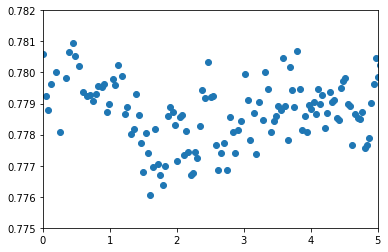

(0.7148, 0.72)

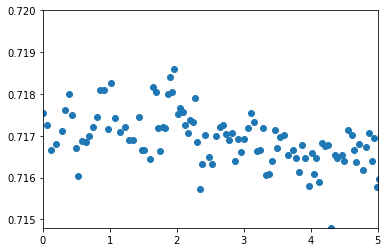

In [99]:
# Check to make sure channels are structured correctly
plt.scatter(features[5][:, 0, 5], features[5][:, 1, 5])
plt.ylim(.775, .782)
plt.xlim(0, 5)
plt.show()

plt.scatter(features[9][:, 0, 5], features[9][:, 1, 5])
plt.xlim(0, 5)
plt.ylim(.7148, .72)

In [76]:
# # # SAVE DATA
# with open('features.txt', 'w') as filehandle:
#     for listitem in features:
#         filehandle.write('%s\n' % listitem)

# with open('labels.txt', 'w') as filehandle:
#     for listitem in labels:
#         filehandle.write('%s\n' % listitem)

In [88]:
# Save data, again

import pickle
pickle.dump(features, open("feat2.txt", "wb"))
pickle.dump(labels, open("labels2.txt", "wb"))

In [91]:
# Read data
features = pickle.load(open("feat2.txt", "rb"))
labels = pickle.load(open("labels2.txt", "rb"))

In [92]:
X = np.array(features)
print(X.shape)

(259, 440, 2, 9)


In [45]:
Y = np.array(labels)
print(Y.shape)

(259,)


(array([34., 20., 28., 23., 21., 29., 32., 20., 20., 32.]),
 array([ 8. , 11.3, 14.6, 17.9, 21.2, 24.5, 27.8, 31.1, 34.4, 37.7, 41. ]),
 <a list of 10 Patch objects>)

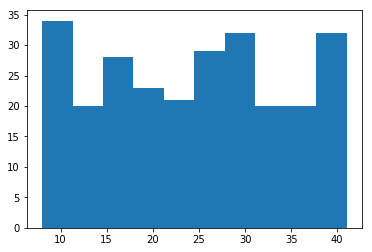

In [73]:
plt.hist(Y)

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=24601)

In [47]:
X_train.shape

(220, 440, 2, 9)

In [249]:
440/5

88.0

In [75]:
model = tf.keras.Sequential([
    Convolution2D(filters=8, kernel_size = (10,2), strides=(1), 
                  padding="same", 
                  input_shape=(440,2, 9), data_format='channels_last', 
                  activation="relu"),
#     MaxPooling2D(pool_size=(2,2), strides=2),
    Flatten(),
#     Dense(256, input_shape=(440,2, 9), kernel_initializer="normal", activation='relu'),
#     Dense(128, activation='relu'),
#     Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])



In [76]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(0.00001), metrics=["mse", "mae"])

In [77]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 440, 2, 8)         1448      
_________________________________________________________________
flatten_2 (Flatten)          (None, 7040)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                112656    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 114,121
Trainable params: 114,121
Non-trainable params: 0
_________________________________________________________________


In [80]:
history = model.fit(X_train, Y_train, epochs=200)

Train on 220 samples
Epoch 1/200
220/220 [==============================] - 1s 3ms/sample - loss: 637.5291 - mean_squared_error: 637.5291 - mean_absolute_error: 23.2743
Epoch 2/200
220/220 [==============================] - 0s 798us/sample - loss: 609.5807 - mean_squared_error: 609.5808 - mean_absolute_error: 22.6647
Epoch 3/200
220/220 [==============================] - 0s 942us/sample - loss: 584.6805 - mean_squared_error: 584.6805 - mean_absolute_error: 22.1132
Epoch 4/200
220/220 [==============================] - 0s 860us/sample - loss: 562.5639 - mean_squared_error: 562.5638 - mean_absolute_error: 21.6027
Epoch 5/200
220/220 [==============================] - 0s 623us/sample - loss: 540.9468 - mean_squared_error: 540.9468 - mean_absolute_error: 21.0961
Epoch 6/200
220/220 [==============================] - 0s 742us/sample - loss: 519.4096 - mean_squared_error: 519.4097 - mean_absolute_error: 20.5771
Epoch 7/200
220/220 [==============================] - 0s 892us/sample - loss: 49

220/220 [==============================] - 0s 912us/sample - loss: 99.7033 - mean_squared_error: 99.7033 - mean_absolute_error: 8.6514
Epoch 55/200
220/220 [==============================] - 0s 686us/sample - loss: 99.6865 - mean_squared_error: 99.6865 - mean_absolute_error: 8.6496
Epoch 56/200
220/220 [==============================] - 0s 639us/sample - loss: 99.6833 - mean_squared_error: 99.6833 - mean_absolute_error: 8.6496
Epoch 57/200
220/220 [==============================] - 0s 808us/sample - loss: 99.7117 - mean_squared_error: 99.7117 - mean_absolute_error: 8.6496
Epoch 58/200
220/220 [==============================] - 0s 748us/sample - loss: 99.6757 - mean_squared_error: 99.6757 - mean_absolute_error: 8.6486
Epoch 59/200
220/220 [==============================] - 0s 867us/sample - loss: 99.6743 - mean_squared_error: 99.6743 - mean_absolute_error: 8.6481
Epoch 60/200
220/220 [==============================] - 0s 887us/sample - loss: 99.6684 - mean_squared_error: 99.6684 - mean_

220/220 [==============================] - 0s 858us/sample - loss: 99.4954 - mean_squared_error: 99.4954 - mean_absolute_error: 8.6338
Epoch 109/200
220/220 [==============================] - 0s 617us/sample - loss: 99.5342 - mean_squared_error: 99.5342 - mean_absolute_error: 8.6354
Epoch 110/200
220/220 [==============================] - 0s 831us/sample - loss: 99.4937 - mean_squared_error: 99.4937 - mean_absolute_error: 8.6342
Epoch 111/200
220/220 [==============================] - 0s 626us/sample - loss: 99.4738 - mean_squared_error: 99.4738 - mean_absolute_error: 8.6329
Epoch 112/200
220/220 [==============================] - 0s 706us/sample - loss: 99.4713 - mean_squared_error: 99.4713 - mean_absolute_error: 8.6325
Epoch 113/200
220/220 [==============================] - 0s 769us/sample - loss: 99.4718 - mean_squared_error: 99.4718 - mean_absolute_error: 8.6318
Epoch 114/200
220/220 [==============================] - 0s 666us/sample - loss: 99.4632 - mean_squared_error: 99.4632 -

220/220 [==============================] - 0s 936us/sample - loss: 99.2713 - mean_squared_error: 99.2713 - mean_absolute_error: 8.6185
Epoch 163/200
220/220 [==============================] - 0s 684us/sample - loss: 99.2761 - mean_squared_error: 99.2760 - mean_absolute_error: 8.6183
Epoch 164/200
220/220 [==============================] - 0s 675us/sample - loss: 99.2888 - mean_squared_error: 99.2888 - mean_absolute_error: 8.6184
Epoch 165/200
220/220 [==============================] - 0s 768us/sample - loss: 99.2632 - mean_squared_error: 99.2632 - mean_absolute_error: 8.6171 - loss: 97.3279 - mean_squared_error: 97.3279 - mean_absolute_error: 8.48
Epoch 166/200
220/220 [==============================] - 0s 805us/sample - loss: 99.2759 - mean_squared_error: 99.2759 - mean_absolute_error: 8.6176
Epoch 167/200
220/220 [==============================] - 0s 643us/sample - loss: 99.2537 - mean_squared_error: 99.2537 - mean_absolute_error: 8.6167
Epoch 168/200
220/220 [=======================

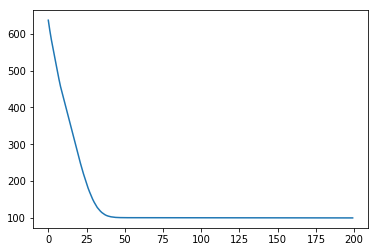

In [86]:
plt.plot(history.history['mean_squared_error'])

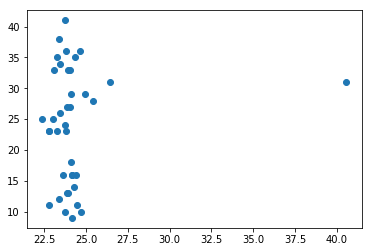

In [87]:
plt.scatter(model.predict(X_test), Y_test)

In [83]:
model.predict(X_test)[0:10]

array([[23.926008],
       [23.265757],
       [22.79941 ],
       [24.403456],
       [25.40382 ],
       [23.449633],
       [40.56915 ],
       [24.118532],
       [24.155685],
       [22.800667]], dtype=float32)

In [84]:
Y_test[0:10]

array([33, 35, 23, 16, 28, 26, 31, 18,  9, 11])

In [85]:
model.evaluate(X_test, Y_test)

39/39 [==============================] - 0s 4ms/sample - loss: 85.5206 - mean_squared_error: 85.5206 - mean_absolute_error: 7.8904


[85.52059603960086, 85.52059, 7.890365]

In [55]:
train_pred = model.predict(X_train)

In [56]:
train_pred

array([[24.705877],
       [23.919703],
       [25.295645],
       [24.017635],
       [24.298737],
       [23.971409],
       [23.335287],
       [24.232195],
       [23.8442  ],
       [24.594982],
       [23.921625],
       [23.900208],
       [24.034744],
       [24.392973],
       [26.049778],
       [23.872265],
       [24.926182],
       [26.064543],
       [24.325108],
       [24.111914],
       [21.573969],
       [24.696115],
       [24.331242],
       [23.781204],
       [25.941189],
       [23.351732],
       [24.463284],
       [23.952438],
       [23.571196],
       [21.068232],
       [24.012745],
       [42.681725],
       [26.23306 ],
       [24.928957],
       [24.32907 ],
       [24.588707],
       [23.90392 ],
       [23.117579],
       [23.287716],
       [24.084381],
       [23.849558],
       [24.316938],
       [25.25266 ],
       [23.558153],
       [21.407236],
       [24.64157 ],
       [23.99197 ],
       [23.927195],
       [24.134354],
       [24.297556],


In [74]:
Y_train

array([24, 38, 38, 17, 37, 17, 41, 28, 38, 13, 29, 33, 31, 31, 38, 31, 11,
       11, 11, 16, 23, 29, 22, 25, 27, 29, 27, 27, 33, 23, 11, 31,  9, 12,
       18, 25, 38, 29, 25, 20, 38, 11, 41, 37, 23, 10, 25, 17, 11,  8, 20,
       10, 25, 17, 14, 20, 16, 38, 41, 24, 11, 27, 17, 13, 11, 35, 26, 29,
       38, 41, 35, 16, 29, 11,  9, 13, 30, 31, 10, 27, 20, 26, 27, 16, 31,
       25, 35, 33, 35, 25, 32, 34, 13, 16, 15, 13,  8, 20, 36, 29, 13, 27,
       25, 20, 22, 27, 23,  8, 29, 37, 23, 33, 20, 12, 35, 11, 34, 27, 22,
       18, 32, 10, 38, 15, 20, 25, 24, 17, 14, 38, 20, 11, 33, 41, 37, 41,
       22, 36, 13, 35, 28, 41, 38, 23, 41, 35, 10, 15, 10, 20, 17, 31, 16,
       30, 27, 30, 31, 33, 16, 28, 38, 40, 13, 13, 17, 10, 10, 15, 41, 20,
       38, 33, 17, 34, 38, 32, 12, 41, 11, 20, 20, 27, 38, 17, 31, 26, 16,
       35, 33, 20, 10, 13, 20, 17, 40, 29, 23, 14, 20, 33, 31, 35, 30, 10,
       40, 17, 32, 23, 35, 41, 20,  8, 18, 40, 23, 25, 20, 20,  9, 29])

## Example plots

In [284]:
data = pd.read_csv(kp_files[9], sep="\t", header=None)
data.columns = ["time", "kpoints", "count", "fps"]
data.kpoints = data.kpoints.apply(lambda x: ast.literal_eval(x.strip("()")))

r_ear = []

for i in range(len(data.kpoints)):
    r_ear.append(data.kpoints[i][4][2])

t = data.time.values

Text(0.5,1,'R ear')

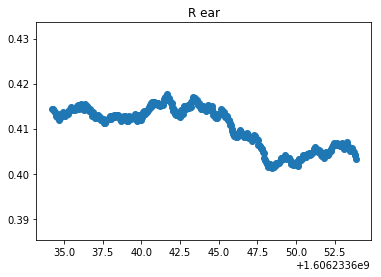

In [285]:
plt.scatter(data.time.values, r_ear)
plt.title("R ear")

In [291]:
fft = np.fft.fft(np.array(r_ear))

In [296]:
is.na(r_ear)

SyntaxError: invalid syntax (<ipython-input-296-3c0a48d27f67>, line 1)

In [295]:
len(r_ear[])

450

In [293]:
np.sin(40 * 2 * np.pi * t) + 0.5 * np.sin(90 * 2 * np.pi * t)

array([-0.92985062,  0.73599438, -1.21271361,  1.0001053 ,  1.46816816,
        0.62967392, -0.16475193, -1.24873096, -0.2780604 ,  0.58604962,
        0.02426294, -0.54309144, -0.24866641, -0.00567832,  0.95006125,
       -0.78845334,  0.05896778,  0.49091095, -0.91243556, -0.49300558,
       -0.36552353,  0.51856077,  0.46264067, -1.39667606,  0.51661664,
       -0.20090672, -0.12295538,  0.5360052 , -1.31119187,  1.12224053,
       -0.45559773,  0.03374568, -0.24566994, -1.43892818,  0.41467501,
       -0.5960589 ,  0.68611984, -0.44342131,  0.32044483,  0.29556098,
       -0.15179283, -1.48288767,  0.29403135, -0.74051579,  0.87134108,
       -0.80556983,  0.98971976, -0.40593279,  0.73193533, -1.42891349,
       -0.69387521, -0.24203758,  0.04910823, -1.35907107, -1.23054444,
        0.99538615,  1.36748368,  0.66773453, -0.74697188, -0.07565257,
        1.01667971,  1.19077739, -0.71245755,  0.3323318 ,  1.39970738,
       -1.21819532, -0.87206314,  0.29027218,  0.47522259, -0.69

In [ ]:
T = t[1] - t[0]  # sampling interval 
N = s.size

# 1/T = frequency
f = np.linspace(0, 1 / T, N)

plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.bar(f[:N // 2], np.abs(fft)[:N // 2] * 1 / N, width=1.5)  # 1 / N is a normalization factor
plt.show()

Text(0.5,1,'R ear')

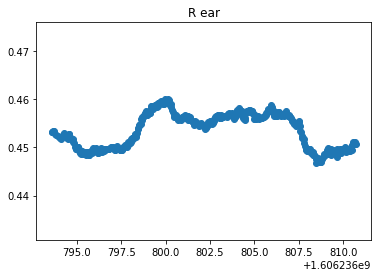

In [279]:
plt.scatter(data.time.values, r_ear)
plt.title("R ear")

Text(0.5,1,'R shoulder')

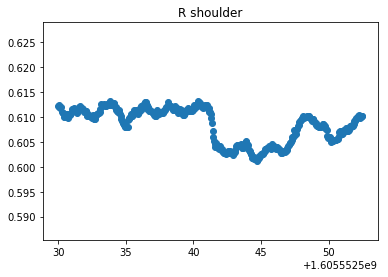

In [58]:
r_shoulder = []

for i in range(len(data.kpoints)):
    r_shoulder.append(data.kpoints[i][3][2])
    
plt.scatter(data.time.values, r_shoulder)
plt.title("R shoulder")